In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
plot_path=start_path+"/../plots/"
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"/src/")
sys.path.insert(4,synth_ar_path+"/plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"/plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Allocations, Switches, and Definitions

In [2]:
campaign="HALO_AC3"
ar_of_day="AR_entire_2"
flight=["RF05"]
reflectivity_for_snow="Z_g"
sector_to_plot="warm"
take_arbitary=True
do_plotting=True
calibrated_radar=False
from simplified_flight_leg_handling import simplified_run_grid_main
with HiddenPrints():
    halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)
flight=cmpgn_cls.flight

flight_dates={
    "RF03":"20220313",
    "RF05":"20220315",
    "RF06":"20220316",
    "RF16":"20220410"}
#halo_era5

## reanalysis dataset (if needed load)

In [3]:
#Load config file
config_file=data_config.load_config_file(major_work_path,"data_config_file")

cmpgn_cls=flightcampaign.HALO_AC3(
                             is_flight_campaign=True,
                             major_path=config_file["Data_Paths"]["campaign_path"],
                             aircraft="HALO",interested_flights=[flight],
                             instruments=["radar","radiometer","sonde"])               

import reanalysis as Reanalysis
file_name="total_columns_"+cmpgn_cls.years[flight[0]]+"_"+\
                    cmpgn_cls.flight_month[flight[0]]+"_"+\
                    cmpgn_cls.flight_day[flight[0]]+".nc"    
        
era5=Reanalysis.ERA5(for_flight_campaign=True,campaign="HALO_AC3",
                  research_flights=flight,
                  era_path=cmpgn_cls.campaign_path+"/data/ERA-5/")
        
ds,era_path=era5.load_era5_data(file_name)
        
        #IVT Processing
ds["IVT_v"]=ds["p72.162"]
ds["IVT_u"]=ds["p71.162"]
ds["IVT"]=np.sqrt(ds["IVT_u"]**2+ds["IVT_v"]**2)
ds["IVT_conv"]=ds["p84.162"]*3600 # units in seconds


C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini
Config-file C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini.ini  already exists
Overall directory of campaign is:  C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3


In [4]:
# ICON File
icon_major_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
hydrometeor_icon_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
print(hydrometeor_icon_path)
icon_resolution=2000 # units m
upsample_time="20min"
date=flight_dates[flight[0]]
interp_icon_hmp_file=flight[0]+"_"+ar_of_day+"_"+"interpolated_HMP.csv"
        
icon_var_list=ICON.lookup_ICON_AR_period_data(cmpgn_cls.name,flight,ar_of_day,
                                                 icon_resolution,
                                                 hydrometeor_icon_path,
                                                 synthetic=False)

ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
    cmpgn_cls,icon_var_list,halo_df,flight,date,
    interpolated_hmp_file=interp_icon_hmp_file,
    interpolated_hmc_file=None,ar_of_day=ar_of_day,
    upsample_time=upsample_time,
    synthetic_icon=False,
    synthetic_flight=False)

if campaign=="HALO_AC3":
    hydrometeor_icon_path=hydrometeor_icon_path+flight[0]+"/"
ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)

halo_icon_hmp=ICON_on_HALO.load_interpolated_hmp()
#halo_icon_hmp["Interp_Precip"]/=1000
halo_icon_hmp.describe()

C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/ICON_LEM_2KM/
RF05_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened


,Minutesofday,Halo_Lat,Halo_Lon,Interp_IWV,Interp_LWP,Interp_IWP,Interp_Precip,Interp_EV
count,11160.000000,11160.000000,11160.000000,11160.000000,11160.000000,11160.000000,11160.000000,11160.000000
mean,832.500000,74.793757,-3.253083,11.757848,68.511633,35.600431,0.080312,0.002754
std,53.695205,1.701549,7.626455,3.268526,44.313822,33.426198,0.120129,0.005026
min,740.000000,72.641344,-17.260609,6.250239,0.000000,0.000000,0.000000,-0.009725
25%,786.000000,72.911366,-9.769786,8.584882,34.277853,2.978089,0.000001,-0.000301
50%,832.500000,75.022407,-2.986523,12.430035,68.659253,23.328375,0.015155,0.002940
75%,879.000000,76.521725,3.276018,14.787056,96.402048,61.781583,0.118637,0.005686
max,925.000000,77.149983,11.719704,16.179518,197.474430,108.244471,0.479636,0.014558


## Flight leg and AR localisation

In [5]:
if flight[0]=="RF03":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-13 10:00","2022-03-13 10:35"]
            internal_times=["2022-03-13 10:37","2022-03-13 11:10"]
            outflow_times=["2022-03-13 11:16","2022-03-13 11:40"]
    
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-15 10:11","2022-03-15 11:13"]
            internal_times=["2022-03-15 11:18","2022-03-15 12:14"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-15 14:30 ","2022-03-15 15:25"]
            internal_times=["2022-03-15 13:20 ","2022-03-15 14:25"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
if flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-16 10:45","2022-03-16 11:21"]
            internal_times=["2022-03-16 11:25","2022-03-16 12:10"]
            outflow_times=["2022-03-16 12:15","2022-03-16 12:50"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]
if flight[0]=="RF16":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-04-10 10:40","2022-04-10 11:08"]
            internal_times=["2022-04-10 11:10","2022-04-10 11:36"]
            outflow_times=["2022-04-10 11:57","2022-04-10 12:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]

new_halo_dict={flight[0]:{"inflow":halo_df.loc[inflow_times[0]:inflow_times[-1]],
                          "internal":halo_df.loc[internal_times[0]:internal_times[-1]],
                          "outflow":halo_df.loc[outflow_times[0]:outflow_times[-1]]}}
from atmospheric_rivers import Atmospheric_Rivers
AR_inflow,AR_outflow=Atmospheric_Rivers.locate_AR_cross_section_sectors(
                                    new_halo_dict,ERA5_on_HALO.halo_era5,
                                    flight[0])
print(AR_inflow["AR_inflow"].keys())
relevant_sondes_dict={}
if take_arbitary:
    for sector in ["warm_sector","core","cold_sector"]:
        print("Analyse frontal sector ",sector)
        #add_sonde=1
        #if sector=="core":
        #    add_sonde=1
        AR_sector_in                       = AR_inflow["AR_inflow_"+sector]
        AR_sector_out                      = AR_outflow["AR_outflow_"+sector]

Index(['time', 'Minutesofday', 'Halo_Lat', 'Halo_Lon', 'Closest_Era_Lat',
       'Closest_Era_Lon', 'Interp_IWV', 'Interp_E', 'Interp_Precip',
       'Interp_LWP', 'Interp_IWP', 'Interp_IVT', 'IVT_max_distance'],
      dtype='object')
Analyse frontal sector  warm_sector
Analyse frontal sector  core
Analyse frontal sector  cold_sector


## Radar dataset

In [6]:
# processing_path packages
import data_config

import measurement_instruments_ql
#import halodataplot as Data_Plotter
import quicklook_dicts

#BAHAMAS.bahamas_ds
radar_dict={}
bahamas_dict={}  
campaign=cmpgn_cls.name

airborne_data_importer_path=major_work_path+\
                                "hamp_processing_py/"+\
                                    "hamp_processing_python/Flight_Data/"+campaign+"/"
print(airborne_data_importer_path)

date=flight_dates[flight[0]]
###############################################################################
inflow=False
# Radar reflectivity
cfg_dict=quicklook_dicts.get_prcs_cfg_dict(flight,date,campaign,cmpgn_cls.campaign_path)
cfg_dict["device_data_path"]=airborne_data_importer_path

# Data Handling 
datasets_dict, data_reader_dict=quicklook_dicts.get_data_handling_attr_dicts()
# Get Plotting Handling
plot_handler_dict, plot_cls_args_dict,plot_fct_args_dict=\
                            quicklook_dicts.get_plotting_handling_attrs_dict()

HALO_Devices_cls=measurement_instruments_ql.HALO_Devices(cfg_dict)
HALO_Devices_cls.update_major_data_path(cmpgn_cls.campaign_path)
Bahamas_cls=measurement_instruments_ql.BAHAMAS(HALO_Devices_cls)
Radar_cls=measurement_instruments_ql.RADAR(HALO_Devices_cls)

radar_ds=Radar_cls.open_version_specific_processed_radar_data(for_calibrated_file=calibrated_radar)

C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/
Look for Radar data in  C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/radar_20220315
C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/radar_20220315_v0*.nc
Opened specific version: C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc\radar_20220315_v0.6.nc


In [7]:
# Radar data
radar_dict["dBZg"]=pd.DataFrame(data=np.array(radar_ds["dBZg"][:]),
                       index=pd.DatetimeIndex(np.array(radar_ds.time[:])),
                       columns=np.array(radar_ds.height[:]))

radar_dict["LDRg"]=pd.DataFrame(data=np.array(radar_ds["LDRg"][:]),
                       index=pd.DatetimeIndex(np.array(radar_ds.time[:])),
                       columns=np.array(radar_ds.height[:]))
if inflow_times[0]<outflow_times[-1]:
    processed_radar=radar_ds.sel({"time":slice(inflow_times[0],outflow_times[-1])})
else:
    processed_radar=radar_ds.sel({"time":slice(outflow_times[0],inflow_times[-1])})
processed_radar

<xarray.Dataset>
Dimensions:     (time: 11160, height: 434)
Coordinates:
  * time        (time) datetime64[ns] 2022-03-15T12:20:00 ... 2022-03-15T15:2...
  * height      (height) float64 0.0 30.0 60.0 ... 1.293e+04 1.296e+04 1.299e+04
Data variables:
    dBZg        (time, height) float64 ...
    Zg          (time, height) float64 ...
    Ze          (time, height) float64 ...
    dBZe        (time, height) float64 ...
    LDRg        (time, height) float64 ...
    RMSg        (time, height) float64 ...
    VELg        (time, height) float64 ...
    SNRg        (time, height) float64 ...
    lat         (time) float64 ...
    lon         (time) float64 ...
    alt         (time) float64 ...
    radar_flag  (time, height) float64 ...
Attributes:
    contact:               henning.dorff@uni-hamburg.de
    flight_date:           20220315
    flight_number:         RF05
    mission:               HALO_AC3
    comment:               Preliminary data! Uncalibrated Data. Only use for ...
    performed_processing:   Entire data gap filled. Clutter removed. Side lob...

### Melting layer detection via Bright Band for Precipitation Phase

In [8]:
#def find_rough_melting_layer(radar_dict):
    
#    height=np.array(radar_dict["height"][:])
#    ldr_df=pd.DataFrame(data=np.array(radar_dict["LDRg"][:]),
#                 columns=height,
#                 index=pd.DatetimeIndex(
#                     np.array(radar_dict["time"])))
    #aircraft_df=pd.DataFrame(data=np.nan,columns=["roll","hdg","sfc","lat","lon"],
    #                  index=pd.DatetimeIndex(\
    #                     np.array(bahamas_dict[flight]["TIME"])))
    #aircraft_df["roll"]=np.array(bahamas_dict[flight]["IRS_PHI"])                             
    #aircraft_df["hdg"]=np.array(bahamas_dict[flight]["IRS_HDG"])
    #aircraft_df["lat"]=np.array(bahamas_dict[flight]["IRS_LAT"])                             
    #aircraft_df["lon"]=np.array(bahamas_dict[flight]["IRS_LON"])
    #aircraft_df=aircraft_df.resample("1s").mean()
    #mask_df=Bahamas_cls.add_surface_mask_to_data(bahamas_dict[flight],
    #                                             prcs_cfg_dict,
    #                                             resolution="10s")
    #mask_df=mask_df.resample("1s").bfill()
    #aircraft_df=aircraft_df.reindex(mask_df.index)
    #aircraft_df["sfc"]=mask_df["sea_ice"]
    #aircraft_df["sfc"]=aircraft_df["sfc"].fillna(method="bfill")

    # ldr detection
    #cutted_aircraft_df=aircraft_df[abs(aircraft_df["roll"])<5]
    #cutted_aircraft_df=cutted_aircraft_df[cutted_aircraft_df["sfc"]>=0]
#    ldr_cutted_df=ldr_df.copy()#.reindex(cutted_aircraft_df.index)

#    lower_height_thres=5
#    low_ldr_df=ldr_cutted_df.iloc[:,lower_height_thres:70]
#    low_ldr_df[low_ldr_df<-17]=np.nan
    
#    ldr_mlayer_height=low_ldr_df.idxmax(axis=1)
#    return ldr_

def find_melting_layer(radar_dict,vertical_value_to_use="max"):    
    ldr_threshold=-17
    lower_height_thres=5
    maximum_height=2000
    maximum_gradient=60
    # based on Austen et al. 2023    
    height=np.array(radar_dict["height"][:])
    ldr_df=pd.DataFrame(data=np.array(radar_dict["LDRg"][:]),
                 columns=height,
                 index=pd.DatetimeIndex(
                     np.array(radar_dict["time"])))

    ldr_cutted_df=ldr_df.copy()#.reindex(cutted_aircraft_df.index)

    low_ldr_df=ldr_cutted_df.iloc[:,lower_height_thres:70]
    #-------------------------------------------------------------------------#
    # LDR threshold
    low_ldr_df[low_ldr_df<ldr_threshold]=np.nan

    # which value to use if a vertical column is above ldr_threshold
    # my method was the maximum value which always shifts the bright band above
    # version auf Austen is 
    if vertical_value_to_use=="max":    
        ldr_mlayer_height=low_ldr_df.idxmax(axis=1)
    elif vertical_value_to_use=="lowest": # Austen et al. 2023
        #this is a bad method but performs well
        mask_of_ldr_values=low_ldr_df/low_ldr_df
        ldr_mlayer_height=mask_of_ldr_values.idxmin(axis=1)
        #for idx in low_ldr_df.index:
        #    vertical_profile=pd.Series(data=low_ldr_df.iloc[idx,:],
        #                               index=)
    
    #-------------------------------------------------------------------------#
    # LDR should always lie below maximum height defined above
    ldr_mlayer_height[ldr_mlayer_height>maximum_height]=np.nan
    
    #-------------------------------------------------------------------------#
    # Gradient criteria (continuity), it is less strong than in Austin et al.
    ldr_ml_height_gradient=ldr_mlayer_height.diff()
    strong_gradient=ldr_ml_height_gradient[\
                        abs(ldr_ml_height_gradient)>maximum_gradient]
    # set value to nan for too strong gradients
    ldr_mlayer_height.loc[strong_gradient.index]=np.nan
    #-------------------------------------------------------------------------#
    # 5s rolling mean
    ldr_mlayer_height=ldr_mlayer_height.rolling("5s",min_periods=5).mean()   
    #-------------------------------------------------------------------------#
    # Melting layer mask
    mlayer_mask=pd.Series(data=np.zeros(ldr_mlayer_height.shape[0]),
                          index=ldr_mlayer_height.index)
    mlayer_mask[~ldr_mlayer_height.isnull()]+=1
    #-------------------------------------------------------------------------#
    # max 10 s gap filling via interpolation
    ldr_mlayer_height=ldr_mlayer_height.interpolate(method="polynomial",order=5,
                                                    limit=10,limit_area="inside",
                                                    limit_direction="both")
    # Extrapolate
    ldr_mlayer_height=ldr_mlayer_height.interpolate(method="polynomial",order=5,
                                                    limit_area="outside",limit=10,
                                                    fill_value="extrapolate")
    condition_1=mlayer_mask==0
    condition_2=~ldr_mlayer_height.isnull()
    both_conditions= condition_1 & condition_2
    mlayer_mask[both_conditions]=2
    #
    mlayer_mask[ldr_mlayer_height.between(0,270,inclusive="right")]=2
    #------------------------------------------------------------------------- #
    #
    return ldr_mlayer_height,low_ldr_df,ldr_cutted_df,mlayer_mask

def classify_precipitation_type(radar_dict, bb_height,bb_mask):
    surface_Zg=radar_dict["Zg"][:,4]
    surface_Zg=surface_Zg.where(surface_Zg!=-888.)
    sfc_zg_series=pd.Series(data=np.array(surface_Zg[:]),
                            index=pd.DatetimeIndex(
                               np.array(surface_Zg.time[:])))
    surface_type=pd.Series(data=np.array(radar_dict["radar_flag"].values[:,0]),
                           index=sfc_zg_series.index)
    
    precip_type_series=pd.Series(data=np.nan,
                                 index=pd.DatetimeIndex(
                                     np.array(surface_Zg.time[:])))
    precip_type_series[sfc_zg_series.isnull()]=0
    precip_type_series[~sfc_zg_series.isnull()]=1.0 # snow
    precip_type_series.loc[bb_mask==1.0]=2.0 # rain
    precip_type_series.loc[bb_mask==2.0]=3.0 # uncertain    
    precip_type_series[surface_type==-0.1]=-1.0
    # take as last conditions do not anymore look for clear rain defined signals
    # but maybe it is not important once applied to the rain reflectivities
    return precip_type_series,sfc_zg_series

## Precipitation (rain) rate, Norris et al. (2020) 

In [9]:
def get_rain_rate(zg_series):
    rain_rate=pd.DataFrame(data=np.nan, index=zg_series.index,
                           columns=["norris","palmer","chandra"])
    rain_rate["norris"]   = 1/466*zg_series**(1/1.47)
    rain_rate["palmer"]   = 1/200*zg_series**(1/1.6)
    rain_rate["chandra"]  = 1/177*zg_series**(1/1.11)
    rain_rate["mean_rain"]= rain_rate.mean(axis=1)
    return rain_rate

def get_snow_rate(zg_series):
    snow_rate=pd.DataFrame(data=np.nan,index=zg_series.index,
                          columns=["schoger","matrosov","heymsfield"])
    snow_rate["schoger"]   = 1/77.67*zg_series**(1/1.22)
    snow_rate["matrosov"]  = 1/56*zg_series**(1/1.2)
    snow_rate["heymsfield"]= 1/10.13*zg_series**(1/1.92)
    snow_rate["mean_snow"] = snow_rate.mean(axis=1) 
    return snow_rate

def take_correct_precipitation_rates(zg_series_dict,surface_mask,bb_mask,z_for_snow="Z_e"):
    precipitation_rate=pd.DataFrame(data=np.nan,index=zg_series.index,
                           columns=["r_norris","r_palmer","r_chandra",
                                   "s_schoger","s_matrosov","s_heymsfield",
                                   "mean_snow","mean_rain","surface","precip_phase"])
    default_rain_rate=get_rain_rate(z_series_dict["zg"])
    if z_for_snow=="Z_e":
        z_snow=z_series_dict["ze"]
    else:
        z_snow=z_series_dict["zg"]
        
    default_snow_rate=get_snow_rate(z_snow)
    #Snow rate
    precipitation_rate["s_schoger"].loc[bb_mask==1]=default_snow_rate["schoger"]
    precipitation_rate["s_matrosov"].loc[bb_mask==1]=default_snow_rate["matrosov"]
    precipitation_rate["s_heymsfield"].loc[bb_mask==1]=default_snow_rate["heymsfield"]
    precipitation_rate["mean_snow"].loc[bb_mask==1]=default_snow_rate["mean_snow"]
    #Rain rate
    precipitation_rate["r_norris"].loc[bb_mask==2]=default_rain_rate["norris"]
    precipitation_rate["r_palmer"].loc[bb_mask==2]=default_rain_rate["palmer"]
    precipitation_rate["r_chandra"].loc[bb_mask==2]=default_rain_rate["chandra"]
    precipitation_rate["mean_rain"].loc[bb_mask==2]=default_rain_rate["mean_rain"]
    precipitation_rate["surface"]=surface_mask.values
    precipitation_rate["precip_phase"].loc[bb_mask==1]="snow"
    precipitation_rate["precip_phase"].loc[bb_mask==2]="rain"
    precipitation_rate["precip_phase"].loc[bb_mask==3]="uncertain"
    precipitation_rate["precip_phase"].loc[bb_mask==-1]="land"
    return precipitation_rate

#precip_times_norris=rain_rate["norris"][2000:28000]
#precip_times_norris=precip_times_norris.where(precip_times_norris>0.0)
#precip_times_norris.mean()
#precip_times_chandra=rain_rate["chandra"][2000:28000]
#precip_times_chandra=precip_times_chandra.where(precip_times_chandra>0.0)
#print(precip_times_chandra)
#sys.exit()
#rain_rate=get_norris_rain_rate(surface_Zg)
#print(rain_rate["mean"].mean())
#sys.exit()
#reflect_fig=plt.figure(figsize=(16,9))
#ax1=reflect_fig.add_subplot(111)
#ax1.plot(rain_rate["norris"][2000:28000],label=str(round(float(),2)))
#ax1.plot(rain_rate["chandra"][2000:28000],label=str(round(float(rain_rate["chandra"][2000:28000].mean()),2)))
#ax1.set_ylim([0,2])
#ax1.legend()

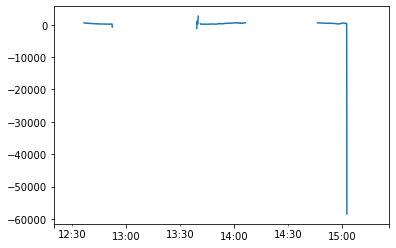

In [10]:
import halodataplot
# Radar reflectivity
processed_radar=halodataplot.replace_fill_and_missing_values_to_nan(
                                processed_radar,["dBZg","Zg","Ze",
                                                 "LDRg","VELg",
                                                 "radar_flag"])        
       
mlayer_height,low_ldr_df,ldr_cutted_df,bb_mask=find_melting_layer(processed_radar)
#    ldr_mlayer_height,low_ldr_df,ldr_cutted_df=find_melting_layer(processed_radar)
mlayer_height.plot()

In [11]:
precip_type_series,zg_series=classify_precipitation_type(processed_radar,mlayer_height,bb_mask)
surface_mask=pd.Series(data=np.array(processed_radar["radar_flag"][:,0]),
                        index=pd.DatetimeIndex(np.array(processed_radar.time[:])))
surface_mask

2022-03-15 12:20:00    0.0
2022-03-15 12:20:01    0.0
2022-03-15 12:20:02    0.0
2022-03-15 12:20:03    0.0
2022-03-15 12:20:04    0.0
                      ... 
2022-03-15 15:25:55    5.0
2022-03-15 15:25:56    5.0
2022-03-15 15:25:57    5.0
2022-03-15 15:25:58    5.0
2022-03-15 15:25:59    5.0
Length: 11160, dtype: float64

In [12]:
surface_Ze=processed_radar["Ze"][:,4]
surface_Ze=surface_Ze.where(surface_Ze!=-888.)
ze_series=pd.Series(data=np.array(surface_Ze[:]),
                            index=pd.DatetimeIndex(
                               np.array(surface_Ze.time[:])))    
z_series_dict={}
z_series_dict["zg"]=zg_series
z_series_dict["ze"]=ze_series
precipitation_rate=take_correct_precipitation_rates(z_series_dict,surface_mask,bb_mask,z_for_snow=reflectivity_for_snow)

Plotting HAMP Cloud Radar (processed)
flag nans
flagging done
dBZ plotted
LDR plotted
Figure saved as: C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_entire_2_Rain_internal_processed_radar_Z_g.png


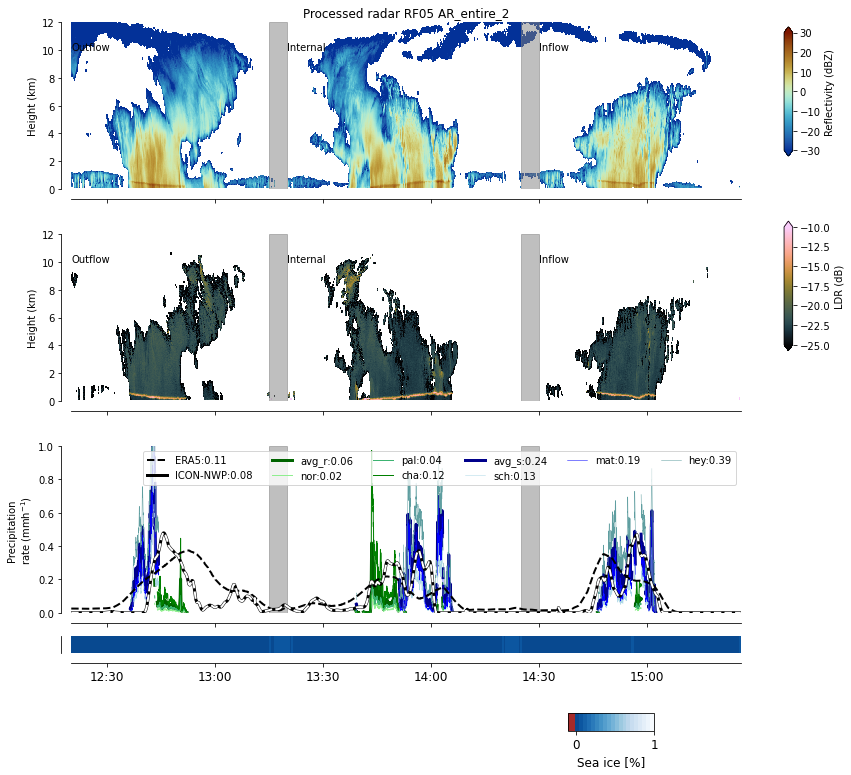

In [13]:
# Now raw_uni_radar and ds (processed uni radar) can be compared
# via plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import colors
from cmcrameri import cm as cmaeri

fig,axs=plt.subplots(4,1,figsize=(12,12),gridspec_kw=dict(height_ratios=(1,1,1.0,0.1)),sharex=True)
y=np.array(processed_radar["height"][:])
statement="Plotting HAMP Cloud Radar (processed"
if not calibrated_radar: statement+=")"
else: statement+=" and calibrated)"
print(statement)
#######################################################################
#######################################################################
### Processed radar
print("flag nans")
processed_radar["dBZg"]=processed_radar["dBZg"].where(processed_radar["radar_flag"].isnull(), drop=True)
processed_radar["Zg"]=processed_radar["Zg"].where(processed_radar["radar_flag"].isnull(), drop=True)
processed_radar["LDRg"]=processed_radar["LDRg"].where(processed_radar["radar_flag"].isnull(), drop=True)
print("flagging done")
surface_Zg=processed_radar["Zg"][:,4]
surface_Zg=surface_Zg.where(surface_Zg!=-888.)

#rain_rate=get_rain_rate(surface_Zg)
#sys.exit()
#processed_radar
time=pd.DatetimeIndex(np.array(processed_radar["dBZg"].time[:]))
#Plotting
C1=axs[0].pcolor(time,y,np.array(processed_radar["dBZg"][:]).T,
                cmap=cmaeri.roma_r,vmin=-30,vmax=30)
print("dBZ plotted")
if inflow_times[0]<outflow_times[-1]:
    axs[0].axvspan(pd.Timestamp(inflow_times[-1]),
               pd.Timestamp(internal_times[0]),
               alpha=0.5, color='grey')
    axs[0].axvspan(pd.Timestamp(internal_times[-1]),
               pd.Timestamp(outflow_times[0]),
               alpha=0.5, color='grey')   
else:
    axs[0].axvspan(pd.Timestamp(outflow_times[-1]),
               pd.Timestamp(internal_times[0]),
               alpha=0.5, color='grey')
    axs[0].axvspan(pd.Timestamp(internal_times[-1]),
               pd.Timestamp(inflow_times[0]),
               alpha=0.5, color='grey')   

cax1=fig.add_axes([0.95, 0.725, 0.01, 0.15])
cb = plt.colorbar(C1,cax=cax1,orientation='vertical',extend="both")
cb.set_label('Reflectivity (dBZ)')
title_str="Processed radar"
if calibrated_radar: title_str+=" and calibrated"
title_str+=" "+flight[0]+" "+ar_of_day
#axs[0].set_title()
axs[0].set_title(title_str)
axs[0].set_xlabel('')
axs[0].set_yticks([0,2000,4000,6000,8000,10000,12000])
axs[0].set_ylim([0,12000])
axs[0].set_yticklabels(["0","2","4","6","8","10","12"])
axs[0].set_xticklabels([])
axs[0].set_ylabel("Altitude (km)")
axs[0].text(pd.Timestamp(inflow_times[0]),10000,"Inflow")
axs[0].text(pd.Timestamp(internal_times[0]),10000,"Internal")
axs[0].text(pd.Timestamp(outflow_times[0]),10000,"Outflow")
axs[0].set_ylabel("Height (km)")
# Radar LDR
C2=axs[1].pcolor(time,y,np.array(processed_radar["LDRg"][:].T),cmap=cmaeri.batlowK,vmin=-25, vmax=-10)        
axs[1].set_yticks([0,2000,4000,6000,8000,10000,12000])
axs[1].set_ylim([0,12000])
axs[1].set_yticklabels(["0","2","4","6","8","10","12"])
print("LDR plotted")
if inflow_times[0]<outflow_times[-1]:
    axs[1].axvspan(pd.Timestamp(inflow_times[-1]),
               pd.Timestamp(internal_times[0]),
               alpha=0.5, color='grey')
    axs[1].axvspan(pd.Timestamp(internal_times[-1]),
               pd.Timestamp(outflow_times[0]),
               alpha=0.5, color='grey')   
else:
    axs[1].axvspan(pd.Timestamp(outflow_times[-1]),
               pd.Timestamp(internal_times[0]),
               alpha=0.5, color='grey')
    axs[1].axvspan(pd.Timestamp(internal_times[-1]),
               pd.Timestamp(inflow_times[0]),
               alpha=0.5, color='grey')   

    #axs[1].xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))        
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))        
axs[1].text(pd.Timestamp(inflow_times[0]),10000,"Inflow")
axs[1].text(pd.Timestamp(internal_times[0]),10000,"Internal")
axs[1].text(pd.Timestamp(outflow_times[0]),10000,"Outflow")
axs[1].set_xticklabels([])
axs[1].set_ylabel("Height (km)")
cax2=fig.add_axes([0.95, 0.5, 0.01, 0.15])

cb = plt.colorbar(C2,cax=cax2,orientation='vertical',extend="both")
cb.set_label('LDR (dB)')
sns.despine(offset=10)
axs[2].plot(halo_era5["Interp_Precip"],lw=2,ls="--",color="k",label="ERA5:"+\
            str(round(float(halo_era5["Interp_Precip"].mean()),2)),zorder=5)
axs[2].plot(halo_icon_hmp["Interp_Precip"],lw=3,ls="-",color="k",label="ICON-NWP:"+\
            str(round(float(halo_icon_hmp["Interp_Precip"].mean()),2)),zorder=6)
axs[2].plot(halo_icon_hmp["Interp_Precip"],lw=2,ls="--",color="w",zorder=7)
axs[2].plot(precipitation_rate["mean_rain"],lw=3,color="darkgreen",
            label="avg_r:"+str(round(float(precipitation_rate["mean_rain"].mean()),2)))
axs[2].plot(precipitation_rate["r_norris"],lw=1,color="lightgreen",
            label="nor:"+str(round(float(precipitation_rate["r_norris"].mean()),2)))
axs[2].plot(precipitation_rate["r_palmer"],lw=1,color="mediumseagreen",
            label="pal:"+str(round(float(precipitation_rate["r_palmer"].mean()),2)))
axs[2].plot(precipitation_rate["r_chandra"],lw=1,color="green",
            label="cha:"+str(round(float(precipitation_rate["r_chandra"].mean()),2)))
# snow 
axs[2].plot(precipitation_rate["mean_snow"],lw=3,color="darkblue",
            label="avg_s:"+str(round(float(precipitation_rate["mean_snow"].mean()),2)))
axs[2].plot(precipitation_rate["s_schoger"],lw=0.5,color="lightblue",
            label="sch:"+str(round(float(precipitation_rate["s_schoger"].mean()),2)))
axs[2].plot(precipitation_rate["s_matrosov"],lw=0.5,color="blue",
            label="mat:"+str(round(float(precipitation_rate["s_matrosov"].mean()),2)))
axs[2].plot(precipitation_rate["s_heymsfield"],lw=0.5,color="cadetblue",
            label="hey:"+str(round(float(precipitation_rate["s_heymsfield"].mean()),2)))

if inflow_times[0]<outflow_times[-1]:
    axs[2].axvspan(pd.Timestamp(inflow_times[-1]),
               pd.Timestamp(internal_times[0]),
               alpha=0.5, color='grey')
    axs[2].axvspan(pd.Timestamp(internal_times[-1]),
               pd.Timestamp(outflow_times[0]),
               alpha=0.5, color='grey')   
else:
    axs[2].axvspan(pd.Timestamp(outflow_times[-1]),
               pd.Timestamp(internal_times[0]),
               alpha=0.5, color='grey')
    axs[2].axvspan(pd.Timestamp(internal_times[-1]),
               pd.Timestamp(inflow_times[0]),
               alpha=0.5, color='grey')   

axs[2].set_ylim([0,1.0])
axs[2].legend(loc="top left",ncol=6)
axs[2].set_xticks=axs[1].get_xticks()
axs[2].set_xticklabels([])
axs[2].set_ylabel("Precipitation\nrate ($\mathrm{mmh}^{-1}$)")
# Add surface mask
# plot AMSR2 sea ice concentration
fs = 14
fs_small = fs - 2
fs_dwarf = fs - 4
marker_size = 15
        
bah_df=pd.DataFrame()
bah_df["sea_ice"]=pd.Series(data=np.array(processed_radar["radar_flag"][:,0]),
                            index=pd.DatetimeIndex(np.array(processed_radar.time[:])))
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
blue_colorbar=cm.get_cmap('Blues_r', 22)
blue_cb=blue_colorbar(np.linspace(0, 1, 22))
brown_rgb = np.array(colors.hex2color(colors.cnames['brown']))
blue_cb[:2, :] = [*brown_rgb,1]
newcmp = ListedColormap(blue_cb)
im = axs[3].pcolormesh(np.array([pd.DatetimeIndex(bah_df["sea_ice"].index),
                                        pd.DatetimeIndex(bah_df["sea_ice"].index)]),
                              np.array([0, 1]),
                              np.array([bah_df["sea_ice"].values/100]),
                              cmap=newcmp, vmin=-0.1, vmax=1,
                              shading='auto')
cax = fig.add_axes([0.7, 0.06, 0.1, axs[3].get_position().height])
C1=fig.colorbar(im, cax=cax, orientation='horizontal')
C1.set_label(label='Sea ice [%]',fontsize=fs_small)
C1.ax.tick_params(labelsize=fs_small)
axs[3].tick_params(axis='x', labelleft=False, 
                          left=False,labelsize=fs_small)
axs[3].tick_params(axis='y', labelleft=False, left=False)
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#time_var=bah_df.index
# time extent:
#time_extent = Measurement_Instruments_QL.\
#                        HALO_Devices.\
#                            numpydatetime64_to_datetime(time_var[-1]) -\
#                        Measurement_Instruments_QL.\
#                            HALO_Devices.numpydatetime64_to_datetime(time_var[0])        
#axs[3].set_xlabel(f"Time (HH:MM) of {str(time_var[round(len(time_var)/2)].values)[:10]}",
#                         fontsize=fs_small)

# Limit axis spacing:
plt.subplots_adjust(hspace=0.35)			# removes space between subplots
box = axs[3].get_position()        
box.y0 = box.y0 + 0.025
box.y1 = box.y1 + 0.025        
axs[3]=axs[3].set_position(box)
radar_str="processed_radar"
#radar_var="zg"
if calibrated_radar: radar_str="calibrated and "+radar_str
fig_name=flight[0]+"_"+ar_of_day+"_Rain_internal_"+radar_str+"_"+reflectivity_for_snow+".png"
fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
print("Figure saved as:",plot_path+fig_name)